# Comparing mouse behavior to HMM with Thompson Sampling

In [22]:
import sys
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
%matplotlib inline 

## load in csv files (from running exportTrials.m)

In [46]:
data_hmm_g = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/hmm_matrix_full_7030_greedy.csv',index_col=0)
data_mouse = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/reduced_7030_02132017.csv',index_col=0)
data_hmm_t = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/hmm_matrix_7030.csv',index_col=0)

datas = [data_hmm_g,data_hmm_t,data_mouse]

# Looking more closely at the switch trials

/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an intege

total # of blocks in dataset: ~334
total # of blocks in dataset: ~167


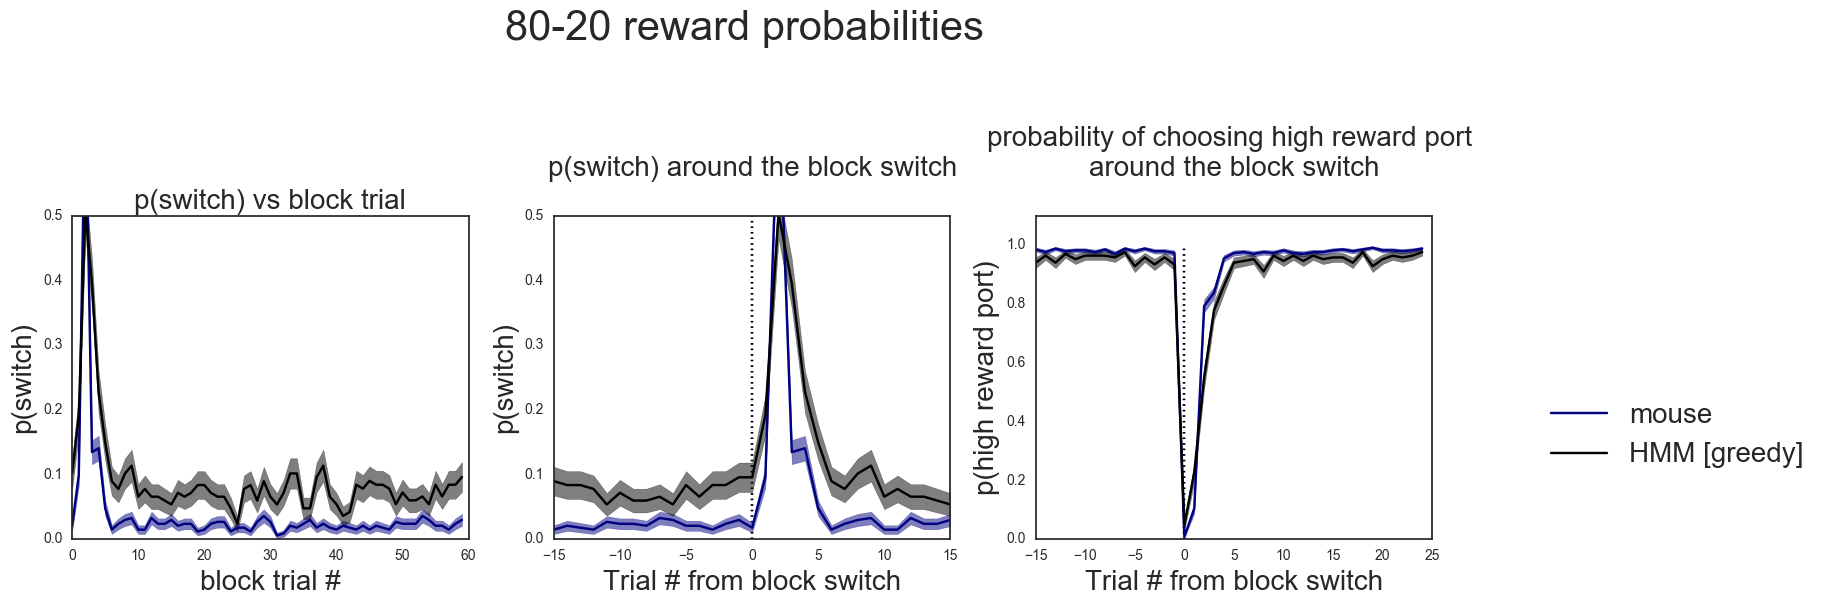

In [24]:
sns.set_style('white')
plt.figure(figsize=(15,5))
plt.suptitle('80-20 reward probabilities',x=0.5,y=1.2,fontsize=30)

labels = ['mouse','HMM [greedy]','HMM [Thompson]']
colors = ['navy','black','grey']

for c,data in enumerate(datas):

    switches = data['Switch'].values

    t_block_unique = np.unique(data['Block Trial'].values)
    p_switch_block = np.zeros((t_block_unique.shape[0],2))
    high_p_port = np.zeros_like(p_switch_block)
    trial_block_count = np.zeros_like(t_block_unique)

    for t in t_block_unique:
        p_switch_block[t,0] = data[data['Block Trial'] == t]['Switch'].mean(axis=0)
        trial_block_count[t] = data[data['Block Trial'] == t].shape[0]
        p_switch_block[t,1] = data[data['Block Trial'] == t]['Switch'].std(axis=0) / np.sqrt(trial_block_count[t])

        high_p_port[t,0] = data[data['Block Trial']==t]['Higher p port'].mean(axis=0)
        high_p_port[t,1] = data[data['Block Trial']==t]['Higher p port'].std(axis=0) / np.sqrt(trial_block_count[t])


    data.index = np.arange(data.shape[0]) # <-- this is important
    switch_points = data[data['Block Trial'] == 0].index.values

    L = 15
    paraswitch = np.zeros((switch_points.shape[0],L*2 + 10))
    paraswitch_port = np.zeros_like(paraswitch)

    for i,point in enumerate(switch_points):
        try:
            paraswitch[i,:] = data.iloc[point-L:point+L+10]['Switch']
            paraswitch_port[i,:] = data.iloc[point-L:point+L+10]['Higher p port']
        except:
            pass

    u = paraswitch.mean(axis=0)
    s = paraswitch.std(axis=0)
    SE = s/np.sqrt(paraswitch.shape[0])

    #plt.figure(figsize=(15,5))
    #plt.suptitle('analysis of blocks where probabilities switched every 50 rewards',x=0.5,y=1.1,fontsize=20)

    plt.subplot(131)
    plt.plot(t_block_unique,p_switch_block[:,0],color=colors[c])
    plt.fill_between(t_block_unique,p_switch_block[:,0]+p_switch_block[:,1],p_switch_block[:,0]-p_switch_block[:,1],color=colors[c],alpha=0.5)
    plt.legend(loc='upper right')
    plt.ylim(0,0.5)
    plt.xlim(0,60)
    plt.xlabel('block trial #',fontsize=20)
    plt.ylabel('p(switch)',fontsize=20)
    plt.title('p(switch) vs block trial',fontsize=20)

    plt.tight_layout()
    print('total # of blocks in dataset: ~%.0f' % (np.sum(data['Block Trial']==0)))

    plt.subplot(132)
    plt.plot(np.arange(-1*L,L+10),u,color=colors[c])
    plt.fill_between(np.arange(-1*L,L+10),u+SE,u-SE,color=colors[c],alpha=0.5)
    plt.vlines(x=0,ymin=0,ymax=0.5,color=colors[c],linestyle='dotted')
    plt.xlabel('Trial # from block switch',fontsize=20)
    plt.ylabel('p(switch)',fontsize=20)
    plt.title('p(switch) around the block switch',fontsize=20,x=0.5,y=1.1)
    plt.xlim(-1*L,L)
    plt.ylim(0,0.5)

    plt.subplot(133)
    u = paraswitch_port.mean(axis=0)
    s = paraswitch_port.std(axis=0)
    SE = s/np.sqrt(paraswitch.shape[0])
    plt.plot(np.arange(-1*L,L+10),u,color=colors[c],label=labels[c])
    plt.fill_between(np.arange(-1*L,L+10),u+SE,u-SE,color=colors[c],alpha=0.5)
    plt.vlines(x=0,ymin=0,ymax=1,color=colors[c],linestyle='dotted')
    plt.xlabel('Trial # from block switch',fontsize=20)
    plt.ylabel('p(high reward port)',fontsize=20)
    plt.title('probability of choosing high reward port \naround the block switch',fontsize=20,x=0.5,y=1.1)
    plt.xlim(-1*L,L+10)
    plt.ylim(0,1.1)
    plt.legend(bbox_to_anchor=(2,0.5),fontsize=20)

    plt.tight_layout()

/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an intege

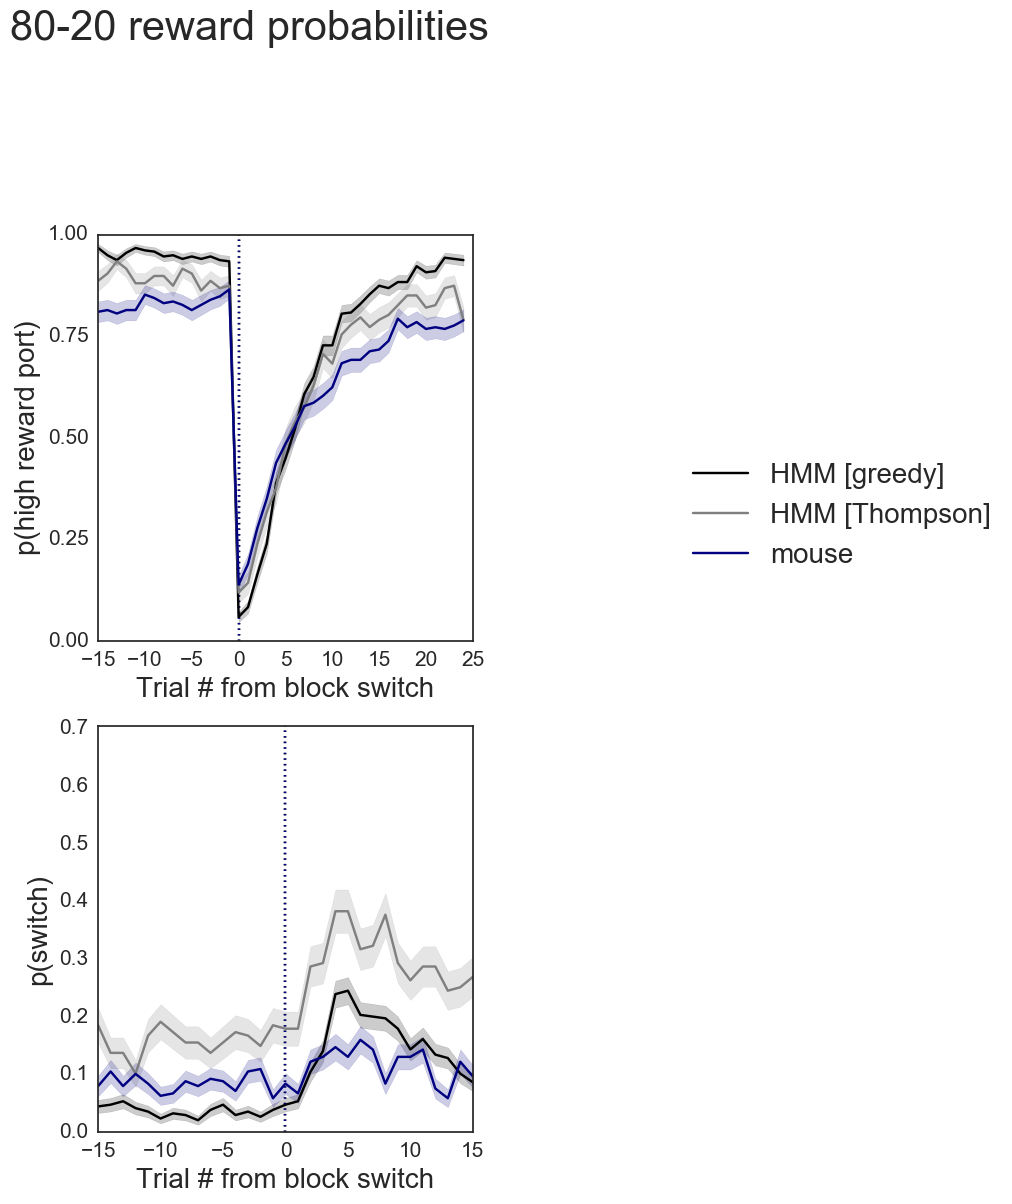

In [47]:
sns.set_style('white')
plt.figure(figsize=(5,10))
plt.suptitle('80-20 reward probabilities',x=0.5,y=1.2,fontsize=30)

labels = ['HMM [greedy]','HMM [Thompson]','mouse']
colors = ['black','grey','navy']

for c,data in enumerate(datas):

    switches = data['Switch'].values

    t_block_unique = np.unique(data['Block Trial'].values)
    p_switch_block = np.zeros((t_block_unique.shape[0],2))
    high_p_port = np.zeros_like(p_switch_block)
    trial_block_count = np.zeros_like(t_block_unique)

    for t in t_block_unique:
        p_switch_block[t,0] = data[data['Block Trial'] == t]['Switch'].mean(axis=0)
        trial_block_count[t] = data[data['Block Trial'] == t].shape[0]
        p_switch_block[t,1] = data[data['Block Trial'] == t]['Switch'].std(axis=0) / np.sqrt(trial_block_count[t])

        high_p_port[t,0] = data[data['Block Trial']==t]['Higher p port'].mean(axis=0)
        high_p_port[t,1] = data[data['Block Trial']==t]['Higher p port'].std(axis=0) / np.sqrt(trial_block_count[t])


    data.index = np.arange(data.shape[0]) # <-- this is important
    switch_points = data[data['Block Trial'] == 0].index.values

    L = 15
    paraswitch = np.zeros((switch_points.shape[0],L*2 + 10))
    paraswitch_port = np.zeros_like(paraswitch)

    for i,point in enumerate(switch_points):
        try:
            paraswitch[i,:] = data.iloc[point-L:point+L+10]['Switch']
            paraswitch_port[i,:] = data.iloc[point-L:point+L+10]['Higher p port']
        except:
            pass

    u = paraswitch.mean(axis=0)
    s = paraswitch.std(axis=0)
    SE = s/np.sqrt(paraswitch.shape[0])

    #plt.figure(figsize=(15,5))
    #plt.suptitle('analysis of blocks where probabilities switched every 50 rewards',x=0.5,y=1.1,fontsize=20)

    plt.subplot(212)
    plt.plot(np.arange(-1*L,L+10),u,color=colors[c])
    plt.fill_between(np.arange(-1*L,L+10),u+SE,u-SE,color=colors[c],alpha=0.2)
    plt.vlines(x=0,ymin=0,ymax=1.0,color=colors[c],linestyle='dotted')
    plt.xlabel('Trial # from block switch',fontsize=20)
    plt.ylabel('p(switch)',fontsize=20)
    #plt.title('p(switch) around the block switch',fontsize=20,x=0.5,y=1.1)
    plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7],fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(-1*L,L)
    plt.ylim(0,0.705)

    plt.subplot(211)
    u = paraswitch_port.mean(axis=0)
    s = paraswitch_port.std(axis=0)
    SE = s/np.sqrt(paraswitch.shape[0])
    plt.plot(np.arange(-1*L,L+10),u,color=colors[c],label=labels[c])
    plt.fill_between(np.arange(-1*L,L+10),u+SE,u-SE,color=colors[c],alpha=0.2)
    plt.vlines(x=0,ymin=0,ymax=1,color=colors[c],linestyle='dotted')
    plt.xlabel('Trial # from block switch',fontsize=20)
    plt.ylabel('p(high reward port)',fontsize=20)
    #plt.title('probability of choosing high reward port \naround the block switch',fontsize=20,x=0.5,y=1.1)
    plt.xlim(-1*L,L+10)
    plt.xticks(fontsize=15)
    plt.yticks([0,0.25,0.5,0.75,1],fontsize=15)
    plt.ylim(0,1)
    plt.legend(bbox_to_anchor=(2.45,0.5),fontsize=20)

    plt.tight_layout()